In [1]:
import pickle
import pandas as pd
import numpy as np
import os
import time
import json
from dotenv import load_dotenv

In [2]:
from openai import OpenAI
load_dotenv()
client = OpenAI(
    # This is the default and can be omitted
    api_key=os.environ.get("OPENAI_API_KEY"),
)

In [3]:
user_train_path = '/home/grads/m/mbismay/llm-based-seq-rec/fashion/fashion_data/processed_data/user_train.json'
user_valid_path = '/home/grads/m/mbismay/llm-based-seq-rec/fashion/fashion_data/processed_data/user_valid.json'
user_test_path = '/home/grads/m/mbismay/llm-based-seq-rec/fashion/fashion_data/processed_data/user_test.json'

In [4]:
with open(user_train_path, 'rb') as f:
    user_train_dict = json.load(f)
with open(user_valid_path, 'rb') as f:
    user_valid_dict = json.load(f)
with open(user_test_path, 'rb') as f:
    user_test_dict = json.load(f)

In [5]:
user_id = '1'
print(user_train_dict[user_id])
print(user_valid_dict[user_id])
print(user_test_dict[user_id])

[11, 12, 13, 14, 15]
[12, 13, 14, 15, 16]
[13, 14, 15, 16, 17]


In [6]:
item_information_path = '/home/grads/m/mbismay/llm-based-seq-rec/fashion/fashion_data/processed_data/processed_item_information.json'
with open(item_information_path, 'r') as f:
    item_information_dict = json.load(f)
print(len(item_information_dict))

6089


In [7]:
ratings_path = '../../fashion_data/processed_data/ratings.csv'
ratings_df = pd.read_csv(ratings_path)
ratings_df.head()

,item,user,rating,timestamp
0,0,0,4.0,1452816000
1,1,0,4.0,1453766400
2,2,0,3.0,1453766400
3,3,0,4.0,1453766400
4,4,0,4.0,1453766400


In [9]:
def get_item_description(item_information):
    item_details = ""
    if 'title' in item_information:
        item_details += item_information['title']
    if 'brand' in item_information:
        item_details += f" Brand: {item_information['brand']}"
    if 'price' in item_information:
        item_details += f" Price: {item_information['price']}"
    if 'description' in item_information:
        item_details += f" Description: {item_information['description']}"
    return item_details

In [17]:
### Train Data Reaosning
train_reasoning_prompts = dict()
check_missed_items = []
for user, item_list in user_train_dict.items():
    # print(user, item_list)
    user_rating_dict = ratings_df[ratings_df['user'] == int(user)]
    # print(user_rating_dict)
    prompt = "You are an expert fashion product recommender. You are provided with a user's list of recent products and their descriptions that the user purchases and whether the user liked it or disliked it. Please go through the list in order -\n"
    for item in item_list[:-1]:
        user_item_rating = user_rating_dict[user_rating_dict['item'] == item]['rating'].values[0]
        if user_item_rating > 3:
            ### Liked
            prompt += f"Liked {get_item_description(item_information_dict[str(item)])}\n"
        else:
            prompt += f"Disliked {get_item_description(item_information_dict[str(item)])}\n"
    target_item = item_list[-1]
    target_item_details = get_item_description(item_information_dict[str(target_item)])
    target_item_rating = user_rating_dict[user_rating_dict['item'] == target_item]['rating'].values[0]
    # print(f"target_item_details: {target_item_details} - {target_item_rating}")

    if target_item_rating > 3:
        prompt += f"""Now, we know that the user will LIKE the next item - {target_item_details}
        As an expert fashion product recommender, do the following steps -
        1. Analyze the provided list of products purchased by the user in order and summarize the user behavior by identifying the characteristics he liked and disliked about the products in at most 100 words.
        2. Explain with reasoning why the user will like the next item - {item_information_dict[str(target_item)]['title']} in atmost 100 words."""
        recommendation = "\nPrediction: Yes"
    else:
        prompt += f"""Now, we know that the user will DISLIKE the next item - {target_item_details}
        As an expert fashion product recommender, do the following steps -
        1. Analyze the provided list of products purchased by the user in order and summarize the user behavior by identifying the characteristics he liked and disliked about the products in at most 100 words.
        2. Explain with reasoning why the user will dislike the next item - {item_information_dict[str(target_item)]['title']} in atmost 100 words."""
        recommendation = "\nPrediction: No"
    # print(f"Prompt: {prompt}")
    train_reasoning_prompts[user] = [prompt, recommendation]
    # break
# print(train_reasoning_prompts)

In [18]:
total_len = 0
all_prompt_lens = []
for user, prompt in train_reasoning_prompts.items():
    all_prompt_lens.append(len(prompt[0].strip().split(' ')))
    total_len += len(prompt[0].strip().split(' '))
print(total_len/len(train_reasoning_prompts))

1368.9662215239591


(array([  3.,   1.,   3.,   2.,   3.,   7.,   8.,   9.,  31.,  52.,  81.,
         96., 149., 138., 149.,  95.,  53.,  19.,  13.,   5.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0., 

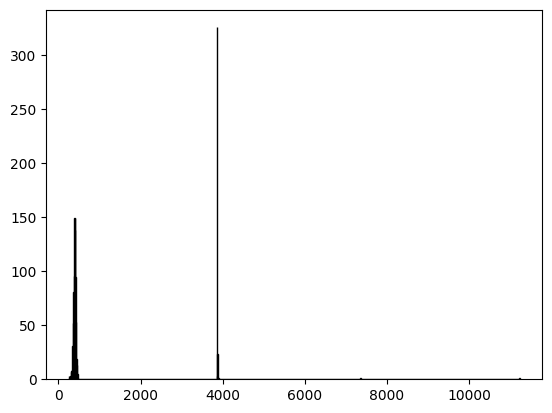

In [19]:
import matplotlib.pyplot as plt

plt.hist(all_prompt_lens, bins=1000, edgecolor='black')

In [38]:
### Valid Data Reaosning
valid_reasoning_prompts = dict()
check_missed_items = []
for user, item_list in user_valid_dict.items():
    # print(user, item_list)
    user_rating_dict = ratings_df[ratings_df['user'] == int(user)]
    # print(user_rating_dict)
    prompt = "You are an expert fashion product recommender. You are provided with a user's list of recent products and their descriptions that the user purchases and whether the user liked it or disliked it. Please go through the list in order -\n"
    for item in item_list[:-1]:
        user_item_rating = user_rating_dict[user_rating_dict['item'] == item]['rating'].values[0]
        if user_item_rating > 3:
            ### Liked
            prompt += f"Liked {get_item_description(item_information_dict[str(item)])}\n"
        else:
            prompt += f"Disliked {get_item_description(item_information_dict[str(item)])}\n"
    target_item = item_list[-1]
    target_item_details = get_item_description(item_information_dict[str(target_item)])
    target_item_rating = user_rating_dict[user_rating_dict['item'] == target_item]['rating'].values[0]
    # print(f"target_item_details: {target_item_details} - {target_item_rating}")

    if target_item_rating > 3:
        prompt += f"""Now, we know that the user will LIKE the next item - {target_item_details}
        As an expert fashion product recommender, do the following steps -
        1. Analyze the provided list of products purchased by the user in order and summarize the user behavior by identifying the characteristics he liked and disliked about the products in at most 100 words.
        2. Explain with reasoning why the user will like the next item - {item_information_dict[str(target_item)]['title']} in atmost 100 words."""
        recommendation = "\nPrediction: Yes"
    else:
        prompt += f"""Now, we know that the user will DISLIKE the next item - {target_item_details}
        As an expert fashion product recommender, do the following steps -
        1. Analyze the provided list of products purchased by the user in order and summarize the user behavior by identifying the characteristics he liked and disliked about the products in at most 100 words.
        2. Explain with reasoning why the user will dislike the next item - {item_information_dict[str(target_item)]['title']} in atmost 100 words."""
        recommendation = "\nPrediction: No"
    # print(f"Prompt: {prompt}")
    valid_reasoning_prompts[user] = [prompt, recommendation]
    # break
print(len(valid_reasoning_prompts))

1273


In [39]:
total_len = 0
all_prompt_lens = []
for user, prompt in valid_reasoning_prompts.items():
    all_prompt_lens.append(len(prompt[0].strip().split(' ')))
    total_len += len(prompt[0].strip().split(' '))
print(total_len/len(valid_reasoning_prompts))

1326.2450903377849


(array([  3.,   4.,   1.,   2.,   2.,   4.,   8.,  16.,  35.,  42.,  82.,
        102., 133., 147., 142., 105.,  64.,  25.,  12.,   4.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0., 

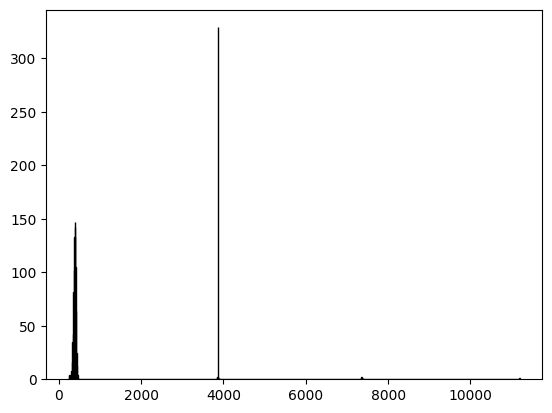

In [40]:
import matplotlib.pyplot as plt

plt.hist(all_prompt_lens, bins=1000, edgecolor='black')

In [41]:
### Test Data Reaosning
test_reasoning_prompts = dict()
check_missed_items = []
for user, item_list in user_test_dict.items():
    # print(user, item_list)
    user_rating_dict = ratings_df[ratings_df['user'] == int(user)]
    # print(user_rating_dict)
    prompt = "You are an expert fashion product recommender. You are provided with a user's list of recent products and their descriptions that the user purchases and whether the user liked it or disliked it. Please go through the list in order -\n"
    for item in item_list[:-1]:
        user_item_rating = user_rating_dict[user_rating_dict['item'] == item]['rating'].values[0]
        if user_item_rating > 3:
            ### Liked
            prompt += f"Liked {get_item_description(item_information_dict[str(item)])}\n"
        else:
            prompt += f"Disliked {get_item_description(item_information_dict[str(item)])}\n"
    target_item = item_list[-1]
    target_item_details = get_item_description(item_information_dict[str(target_item)])
    target_item_rating = user_rating_dict[user_rating_dict['item'] == target_item]['rating'].values[0]
    # print(f"target_item_details: {target_item_details} - {target_item_rating}")

    if target_item_rating > 3:
        prompt += f"""Now, we know that the user will LIKE the next item - {target_item_details}
        As an expert fashion product recommender, do the following steps -
        1. Analyze the provided list of products purchased by the user in order and summarize the user behavior by identifying the characteristics he liked and disliked about the products in at most 100 words.
        2. Explain with reasoning why the user will like the next item - {item_information_dict[str(target_item)]['title']} in atmost 100 words."""
        recommendation = "\nPrediction: Yes"
    else:
        prompt += f"""Now, we know that the user will DISLIKE the next item - {target_item_details}
        As an expert fashion product recommender, do the following steps -
        1. Analyze the provided list of products purchased by the user in order and summarize the user behavior by identifying the characteristics he liked and disliked about the products in at most 100 words.
        2. Explain with reasoning why the user will dislike the next item - {item_information_dict[str(target_item)]['title']} in atmost 100 words."""
        recommendation = "\nPrediction: No"
    # print(f"Prompt: {prompt}")
    test_reasoning_prompts[user] = [prompt, recommendation]
    # break
print(len(test_reasoning_prompts))

1273


In [42]:
total_len = 0
all_prompt_lens = []
for user, prompt in test_reasoning_prompts.items():
    all_prompt_lens.append(len(prompt[0].strip().split(' ')))
    total_len += len(prompt[0].strip().split(' '))
print(total_len/len(test_reasoning_prompts))

457.17753338570304


(array([  1.,   1.,   0.,   2.,   7.,   0.,   4.,   4.,   2.,  11.,  10.,
         24.,  26.,  22.,  57.,  52.,  80.,  83.,  74.,  96.,  93., 400.,
         77.,  56.,  34.,  19.,   7.,   6.,   3.,   2.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0., 

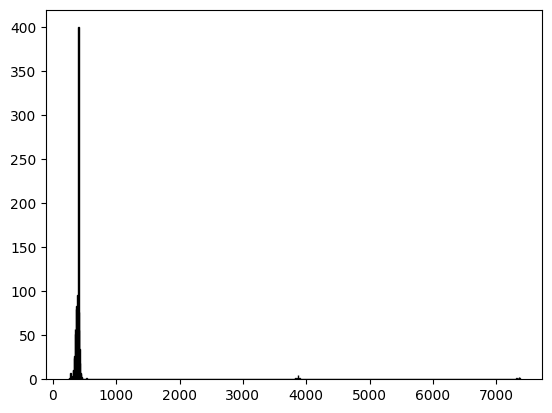

In [43]:
import matplotlib.pyplot as plt

plt.hist(all_prompt_lens, bins=1000, edgecolor='black')

In [44]:
very_long_prompts_users = set()
for user, prompt in test_reasoning_prompts.items():
    if len(prompt[0].strip().split(' ')) > 500:
        very_long_prompts_users.add(user)
for user, prompt in train_reasoning_prompts.items():
    if len(prompt[0].strip().split(' ')) > 500:
        very_long_prompts_users.add(user)
for user, prompt in valid_reasoning_prompts.items():
    if len(prompt[0].strip().split(' ')) > 500:
        very_long_prompts_users.add(user)

In [45]:
very_long_prompts_users = list(very_long_prompts_users)
print(len(very_long_prompts_users))

367


In [48]:
for user in very_long_prompts_users:
    train_reasoning_prompts.pop(user, None)
    valid_reasoning_prompts.pop(user, None)
    test_reasoning_prompts.pop(user, None)
print(len(train_reasoning_prompts), len(valid_reasoning_prompts), len(test_reasoning_prompts))

906 906 906


In [53]:
reasoning_prompt_path = './reasoning_prompt_data/reasoning_prompt_train.pkl'
with open(reasoning_prompt_path, 'wb') as f:
    pickle.dump(train_reasoning_prompts, f)
    f.close()

In [54]:
reasoning_prompt_path = './reasoning_prompt_data/reasoning_prompt_valid.pkl'
with open(reasoning_prompt_path, 'wb') as f:
    pickle.dump(valid_reasoning_prompts, f)
    f.close()

In [55]:
reasoning_prompt_path = './reasoning_prompt_data/reasoning_prompt_test.pkl'
with open(reasoning_prompt_path, 'wb') as f:
    pickle.dump(test_reasoning_prompts, f)
    f.close()

In [56]:
user = '32'
print(train_reasoning_prompts[user])
print(valid_reasoning_prompts[user])
print(test_reasoning_prompts[user])

["You are an expert fashion product recommender. You are provided with a user's list of recent products and their descriptions that the user purchases and whether the user liked it or disliked it. Please go through the list in order -\nLiked TitFus Chunky Knit Infinity Scarf Unisex Super Soft Acrylic/Wool (Burgandy) Brand: TitFus Description: \n\nThe product is a burgundy infinity scarf, which is vibrant, thick, warm, and soft but may be itchy and scratchy around the neck. It arrives quickly and is longer than most.\nLiked Ninimour- Fashion Summer Casual Women's Dress (S, Gray) Brand: Ninimour Description: \n\nThe product is a cute dress with simple design and amazing colors. It fits great and exceeds expectations for the price. However, the dress may be too short, colors may not match the picture, and the material may be see-through and thin.\n\nNote: I have tried to keep the description\nLiked Mixmax Women Flowy Sheer Crop Sleeves Loose Chiffon Kimono Cardigan Blouse Top Price: $10.9

In [20]:
user = '32'
content = train_reasoning_prompts[user][0]
groundtruth = train_reasoning_prompts[user][1]
print(content)
print('*'*100)
response = client.chat.completions.create(
  model="gpt-3.5-turbo",
  messages=[
    {
      "role": "user",
      "content": content
    }
  ],
  temperature=0,
  max_tokens=256,
  top_p=0.75
)


response = response.choices[0].message.content
print(response)
len(response.split(' '))

You are an expert fashion product recommender. You are provided with a user's list of recent products and their descriptions that the user purchases and whether the user liked it or disliked it. Please go through the list in order -
Liked TitFus Chunky Knit Infinity Scarf Unisex Super Soft Acrylic/Wool (Burgandy) Brand: TitFus Description: 

The product is a burgundy infinity scarf, which is vibrant, thick, warm, and soft but may be itchy and scratchy around the neck. It arrives quickly and is longer than most.
Liked Ninimour- Fashion Summer Casual Women's Dress (S, Gray) Brand: Ninimour Description: 

The product is a cute dress with simple design and amazing colors. It fits great and exceeds expectations for the price. However, the dress may be too short, colors may not match the picture, and the material may be see-through and thin.

Note: I have tried to keep the description
Liked Mixmax Women Flowy Sheer Crop Sleeves Loose Chiffon Kimono Cardigan Blouse Top Price: $10.99 - $19.99 

127